In [1]:
# Import all necessary libraries.
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from datetime import datetime
import numpy as np
import tensorflow as tf
import os
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt


C:\Users\Mauro\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Mauro\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Mauro\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Mauro\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

In [3]:
reset_graph()

In [4]:
N = 1000
X, y = make_moons(N, noise=0.1, random_state=42)

In [5]:
y = y.reshape(-1, 1)


test_ratio = 0.2
test_size = int(N * test_ratio)
x_train = X[:-test_size]
x_test = X[-test_size:]
y_train = y[:-test_size]
y_test = y[-test_size:]

In [6]:
x_test_original = x_test

y_test_original = y_test


x_train = np.c_[np.ones((N-test_size, 1)), x_train, x_train**2, x_train**3]

x_test = np.c_[np.ones((test_size, 1)), x_test, x_test**2, x_test**3]



In [7]:
n_inputs = 7

learning_rate = 0.88

logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [8]:
initializer = tf.random_uniform([n_inputs, 1], -1.0, 1.0, seed=42)
theta = tf.Variable(initializer, name="theta")
logits = tf.matmul(X, theta, name="logits")
y_proba = tf.sigmoid(logits)

In [9]:
loss = tf.losses.log_loss(y, y_proba, scope="loss")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
loss_summary = tf.summary.scalar('log_loss', loss)



init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
n_epochs = 10001
minibatch_size = 50
n_batches = int(np.ceil(N / minibatch_size))

save_path = "/tmp/my_model.ckpt"
checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

intervalo_save = 500

with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # Se o ficheiro de checkpoint existir, restaura o modelo e carregue a época
        with open(checkpoint_epoch_path, "rb") as f:
            epoca_inicial = int(f.read())
        print("Training was interrupted. Continuing at epoch", epoca_inicial)
        saver.restore(sess, checkpoint_path)
    else:
        #Se o ficheiro não existir a época é 0
        epoca_inicial = 0
        sess.run(init)
        
    for epoch in range(epoca_inicial, n_epochs):
                    
        for i in range(0, N, minibatch_size):
            
            random_indices = np.random.randint(0, len(x_train), 1)
            X_batch = x_train[random_indices]
            y_batch = y_train[random_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: x_test, y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % intervalo_save == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: x_test, y: y_test})
    os.remove(checkpoint_epoch_path)
    


Epoch: 0 	Loss: 0.44689023
Epoch: 500 	Loss: 0.019735057
Epoch: 1000 	Loss: 0.014715571
Epoch: 1500 	Loss: 0.015228681
Epoch: 2000 	Loss: 0.012700148
Epoch: 2500 	Loss: 0.012870451
Epoch: 3000 	Loss: 0.013252902
Epoch: 3500 	Loss: 0.012658861
Epoch: 4000 	Loss: 0.012511212
Epoch: 4500 	Loss: 0.012498107
Epoch: 5000 	Loss: 0.011319526
Epoch: 5500 	Loss: 0.010005746
Epoch: 6000 	Loss: 0.013224695
Epoch: 6500 	Loss: 0.009947977
Epoch: 7000 	Loss: 0.010054564
Epoch: 7500 	Loss: 0.009017415
Epoch: 8000 	Loss: 0.009518952
Epoch: 8500 	Loss: 0.010325977
Epoch: 9000 	Loss: 0.009666172
Epoch: 9500 	Loss: 0.009093588
Epoch: 10000 	Loss: 0.008407083


In [11]:
y_pred = (y_proba_val >= 0.5)

In [12]:
print(precision_score(y_test, y_pred))

1.0


In [13]:
y_pred = y_pred.reshape(-1)

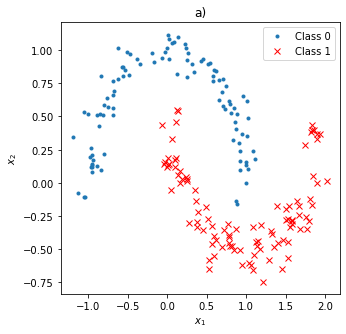

In [14]:


idx0 = np.argwhere(y_pred == False)
idx1 = np.argwhere(y_pred == True)

fig = plt.figure(figsize=(5,5))
plt.plot(x_test_original[idx0,0], x_test_original[idx0,1], '.', label='Class 0')
plt.plot(x_test_original[idx1,0], x_test_original[idx1,1], 'rx', label='Class 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('a)')
plt.legend()
plt.show()